In [40]:
provider

kuni alex


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
ex_rates = pd.read_csv("CardON/ex_rates.csv")
payments = pd.read_csv("payments.csv")
providers = pd.read_csv("providers.csv")

In [43]:
print(len(ex_rates))
print(len(payments))
print(len(providers))


22
393032
937


In [44]:
ex_rates.head()

,rate,destination
0,0.586865,AZN
1,1.041829,EUR
2,0.128461,HKD
3,0.000712,KRW
4,0.650000,AUD


In [47]:
payments.head(5)

,eventTimeRes,amount,cur,payment,cardToken
0,2024-11-24 21:00:00,700.0,RUB,c77be33e8db2f5352ebbc0a1b3f10e3e,336d5ebc5436534e61d16e63ddfca327
1,2024-11-24 21:00:01,180.0,BRL,0ab79b6d41d6e887e84ec4a85ea33733,336d5ebc5436534e61d16e63ddfca327
2,2024-11-24 21:00:01,945.9,RUB,c9a03cbbe592f930d52416b049bc1d1a,336d5ebc5436534e61d16e63ddfca327
3,2024-11-24 21:00:01,35.0,BRL,90a88e0d5b6bfff12909878f265cc2f4,336d5ebc5436534e61d16e63ddfca327
4,2024-11-24 21:00:01,90.0,BRL,f3adde51de36a39508d11d4bf4a98edc,336d5ebc5436534e61d16e63ddfca327


TIME - дата и время, с которого состояние провайдера становится актуальным для платежей

ID - идентификатор провайдера

CONVERSION - идентификатор провайдера (отношение успешных к неуспешным платежам)

AVG_TIME - среднее время выполнения платежа на провайдере

MIN_SUM - минимальная сумма платежа (минимальный чек покупки)

MAX_SUM - максимальная сумма платежа (максимальный чек покупки)

LIMIT_MAX - максимальная общая сумма на провайдере за сутки

(припревышении значения перестают проходить платежи)

LIMIT_MIN - минимальнаяобщая сумма на провайдере за сутки

(принедостижении значения получаем штрафы за невыработку объема)

LIMIT_BY_CARD - лимитпосумме платежей в разрезе одной карты плательщика

COMMISSION - комиссия, взимаемая провайдером

CURRENCY - валютапровайдера

Понять, какая разумная CONVERSION и AVG_TIME для провайдера. Это один из самых важных критериев: как же мы распределеим те или иные параметры (они зависят друг от друга). Опираться необходимо на цель заработать денег.

Лимит - важный параметр. Штраф - 1% от минимального лимита, если лимит не достигнут



In [64]:
providers['ID'].unique()

array([ 0, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 25, 24, 27, 22,  1,  2,  3,  4,  5,  6,  7,  8,
       23, 10, 11,  9, 13, 14, 15, 16, 17, 18, 19, 20, 12, 21])

In [59]:
providers_normalized = providers.copy()
providers_normalized['TIME'] = pd.to_datetime(providers_normalized['TIME'])
numeric_columns = ['CONVERSION', 'AVG_TIME', 'MIN_SUM', 'MAX_SUM', 'LIMIT_MAX', 'LIMIT_MIN', 'COMMISSION']

for column in numeric_columns:
    min_val = providers_normalized[column].min()
    max_val = providers_normalized[column].max()
    providers_normalized[column] = (providers_normalized[column] - min_val) / (max_val - min_val)

In [60]:
providers_normalized.head(5)

,TIME,ID,CONVERSION,AVG_TIME,MIN_SUM,MAX_SUM,LIMIT_MIN,LIMIT_MAX,LIMIT_BY_CARD,COMMISSION,CURRENCY
0,2024-11-24 21:00:00,0,0.0,0.5,0.750,0.384615,0.666667,0.305913,-,0.571429,UZS
1,2024-11-24 21:00:00,26,0.6,0.9,0.750,0.461538,0.333333,0.452442,-,0.857143,MYR
2,2024-11-24 21:00:00,28,0.6,0.7,0.125,0.923077,0.666667,0.511568,-,0.857143,MYR
3,2024-11-24 21:00:00,29,0.6,0.3,0.000,0.923077,0.888889,0.352185,-,0.428571,USD
4,2024-11-24 21:00:00,30,0.0,0.0,0.375,0.615385,0.777778,0.786632,-,1.000000,USD


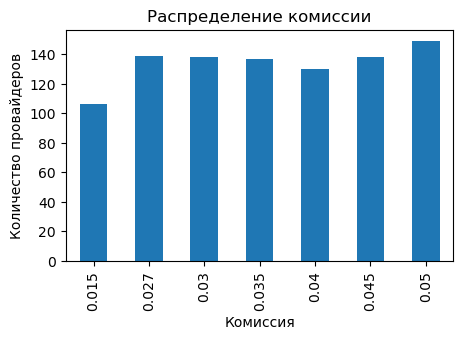

In [34]:
plt.figure(figsize=(5, 3))

providers['COMMISSION'].value_counts().sort_index().plot(kind='bar')

plt.title('Распределение комиссии')
plt.xlabel('Комиссия')
plt.ylabel('Количество провайдеров')
plt.show()# Создание столбчатой диаграммы
plt.bar(categories, values, color='skyblue')

# Добавление подписей к каждому столбцу
for i, value in enumerate(values):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom')

# Настройки графика
plt.xlabel('Категории')
plt.ylabel('Количество')
plt.title('Столбчатая диаграмма с подписями')
plt.ylim(0, max(values) + 5)  # Увеличиваем верхнюю границу для удобства

# Показать график
plt.show()

In [63]:
def calculate_provider_score(row, amount, currency, payment_time):
    score = 0
    conversion_score = row['CONVERSION'] * 40
    commission_score = (1 - row['COMMISSION']) * 25
    avg_time_score = (1 - row['AVG_TIME']) * 20
    

    
    return score